# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Everett Sussman, Jan Geffert

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [257]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline
sns.set_context("poster")

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [258]:
# Create Dataframes
trainDf = pd.read_csv("Bikeshare_train.csv")
testDf = pd.read_csv("Bikeshare_test.csv")

In [259]:
trainDf.head()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,2,5,0,2,1,2,24,26,76.5833,0.118167,6073
1,1,4,12,0,2,1,1,15,19,73.3750,0.174129,6606
2,2,2,6,0,4,1,1,26,28,56.9583,0.253733,7363
3,3,4,12,0,0,0,1,0,4,58.6250,0.169779,2431
4,4,3,9,0,3,1,3,23,23,91.7083,0.097021,1996


In [260]:
# trainDf summary statistics
trainDf.shape

(331, 12)

In [261]:
# testDf summary statistics
testDf.shape

(400, 12)

### Number of Rentals per Day
We first want to get a sense of how many bikes are rented per day.

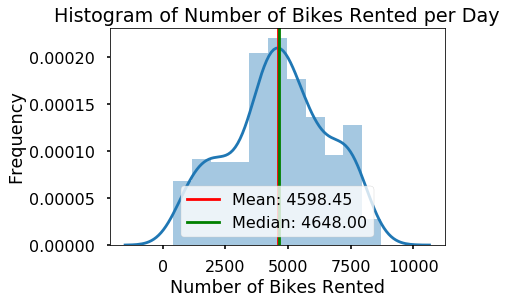

In [262]:
# General histogram of count data

meanBikesRented = np.mean(trainDf["count"])
medianBikesRented = np.median(trainDf["count"])


fig, ax = plt.subplots(1)
ax = sns.distplot(trainDf["count"])
ax.set_title("Histogram of Number of Bikes Rented per Day")
ax.set_xlabel("Number of Bikes Rented")
ax.set_ylabel("Frequency")

ax.axvline(x = meanBikesRented, color="r", label = "Mean: {0:.2f}".format(meanBikesRented))
ax.axvline(x = medianBikesRented, color="g", label = "Median: {0:.2f}".format(medianBikesRented))
ax.legend()

The histogram above shows a fairly symmetrical distribution of values, as the mean and median are very similar. On a typical day, 4648 bikes are rented.

### Weekdays vs. Weekends

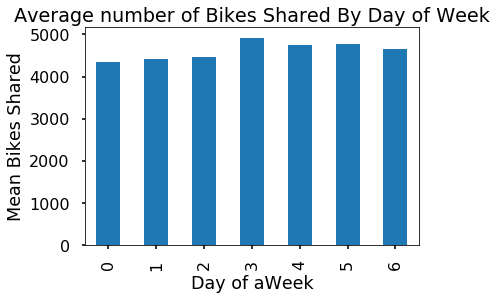

In [263]:
dayGroup = trainDf.groupby("day_of_week", as_index=True)
ax = dayGroup["count"].mean().plot(kind="bar", title="Average number of Bikes Shared By Day of Week")
ax.set_xlabel("Day of aWeek")
ax.set_ylabel("Mean Bikes Shared")

In [264]:
# Find mean for weekdays, mean for weekends
weekMean = np.mean(dayGroup["count"].mean()[1:-2])
weekendMean = np.mean([dayGroup["count"].mean()[0],dayGroup["count"].mean()[6]])
print("Mean bikes rented during the week: {}, Mean bikes rented during the weekend: {}".format(weekMean, weekendMean))

Mean bikes rented during the week: 4634.760765349032, Mean bikes rented during the weekend: 4503.6314465408805


We find that, on average, slightly more bikes are rented during the week. This suggests the usage of rental bikes by commuters.

### Holidays

([<matplotlib.axis.XTick at 0x1c2991c550>,
 <a list of 2 Text xticklabel objects>)

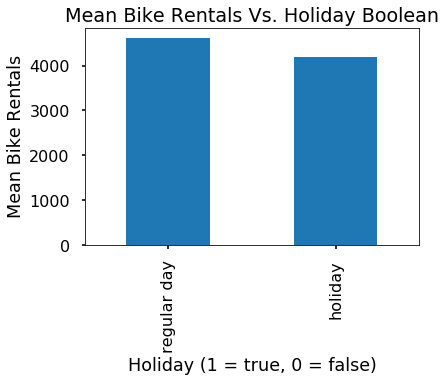

In [265]:
# Holiday Analysis
holidayGroup = trainDf.groupby("holiday")
ax = holidayGroup["count"].mean().plot(kind="bar", title="Mean Bike Rentals Vs. Holiday Boolean")
ax.set_xlabel("Holiday (1 = true, 0 = false)")
ax.set_ylabel("Mean Bike Rentals")
plt.xticks([0,1], ["regular day", "holiday"])

In [266]:
hMeans = holidayGroup["count"].mean()
print("Mean Bike Rentals during a non-Holiday: {}, Mean Bike Rentals during a Holiday: {}.".format(hMeans[0], hMeans[1]))

Mean Bike Rentals during a non-Holiday: 4612.171875, Mean Bike Rentals during a Holiday: 4199.181818181818.


We find that, on average, more bikes are rented during a non-holiday. This further hints at the commuter-hypothesis.

### Seasonal effects

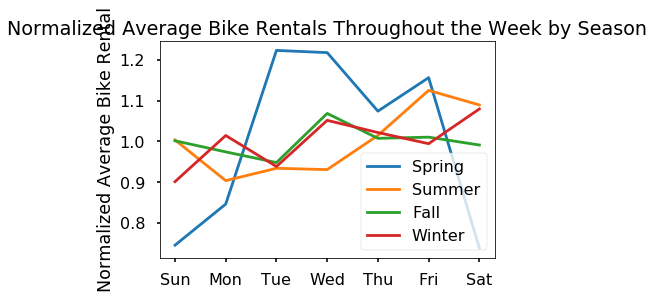

In [267]:
seasonDayGroup = trainDf.groupby(["season", "day_of_week"])["count"].mean()
fig, ax = plt.subplots(1)
seasonNames = ["Spring", "Summer", "Fall", "Winter"]
for season in range(1,5):
    mean = np.mean(seasonDayGroup[season])
    normalizedRentals = list(map(lambda x: x / mean, seasonDayGroup[season]))
    ax.plot(normalizedRentals, label=seasonNames[season-1])
    ax.legend()
    ax.set_title("Normalized Average Bike Rentals Throughout the Week by Season")
    plt.xticks(range(7), ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
    ax.set_ylabel("Normalized Average Bike Rental")

After normalizing the rentals of each season by dividing by the seasonal average, we find that there is considerably more variation in the spring time than in the other seasons.  Also, in the spring, weekends are surprisingly unpopular in terms of average bike rentals compared to the weekdays.  However, in contrast, in the summer, Fridays are very popular.  

In [268]:
### Weather Effects

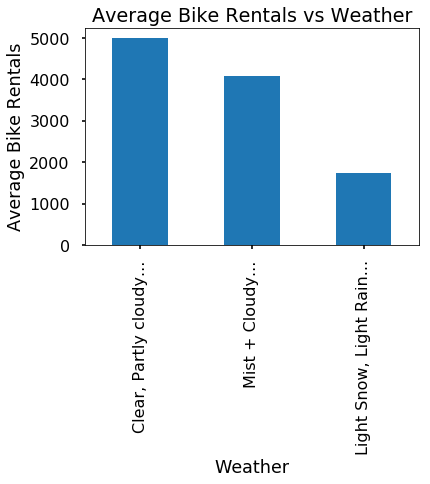

In [269]:
weatherGroup = trainDf.groupby("weather")["count"].mean()

ax = weatherGroup.plot(kind="bar", title="Average Bike Rentals vs Weather")
plt.xticks(range(0,3), ["Clear, Partly cloudy...", "Mist + Cloudy...", "Light Snow, Light Rain..."])
ax.set_xlabel("Weather")
ax.set_ylabel("Average Bike Rentals")

In [270]:
# Print out means:
weatherDiff = []

for weather in range(1,4):
    weatherMean = np.mean(weatherGroup[weather])
    weatherDiff.append(weatherMean - meanBikesRented)
    if weatherDiff[-1] > 0:
        print("Weather {} has a mean of: {}, which is {} more than the annual mean.".format(weather, weatherMean, np.abs(weatherDiff[-1])))
    else:
        print("Weather {} has a mean of: {}, which is {} less than the annual mean.".format(weather, weatherMean, np.abs(weatherDiff[-1])))

Weather 1 has a mean of: 5001.476415094339, which is 403.02928518497356 more than the annual mean.
Weather 2 has a mean of: 4077.1651376146788, which is 521.2819922946869 less than the annual mean.
Weather 3 has a mean of: 1736.2, which is 2862.247129909366 less than the annual mean.


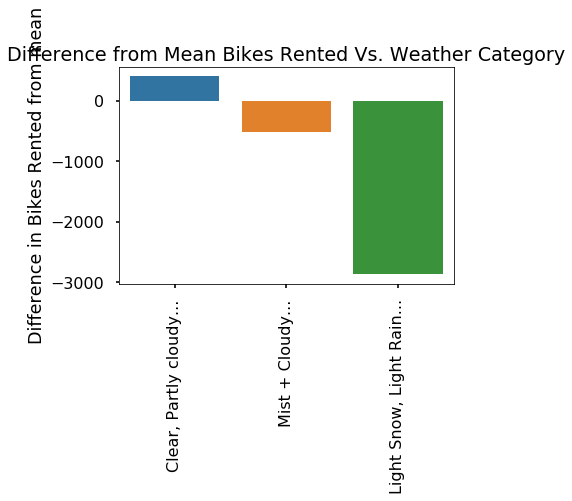

In [271]:
fig, ax = plt.subplots(1)
ax = sns.barplot(list(range(3)), weatherDiff)
ax.set_title("Difference from Mean Bikes Rented Vs. Weather Category")
plt.xticks(range(0,3), ["Clear, Partly cloudy...", "Mist + Cloudy...", "Light Snow, Light Rain..."], rotation=90)
ax.set_ylabel("Difference in Bikes Rented from mean")

As expected by common sense, bike usage drops as the weather gets worse.

### Temperature

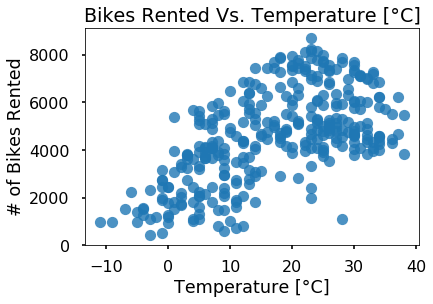

In [272]:
fig, ax = plt.subplots(1)
ax = sns.regplot(trainDf["temp"], trainDf["count"], fit_reg=False)
ax.set_title("Bikes Rented Vs. Temperature [°C]")
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("# of Bikes Rented")

There seems to be a generally positive correlation of *number of bikes rented* and *temperature, which makes sense, given our prior findings. At temperatures of 25 degrees or more, however, higher temperatures are associated with a reduction in ridership, presumably because riding becomes more cumbersome (and sweaty).

### Non-linear Dependencies

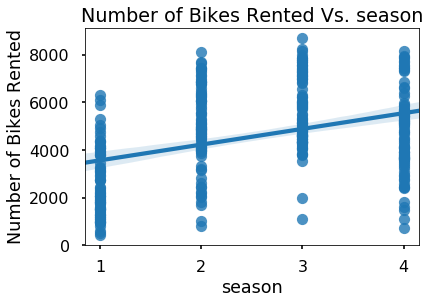

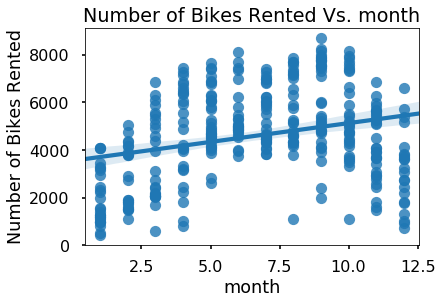

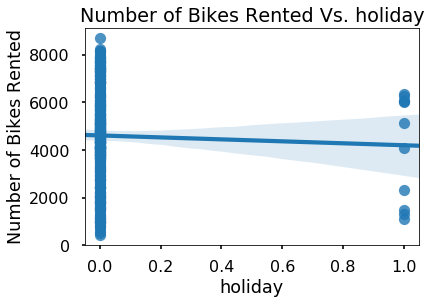

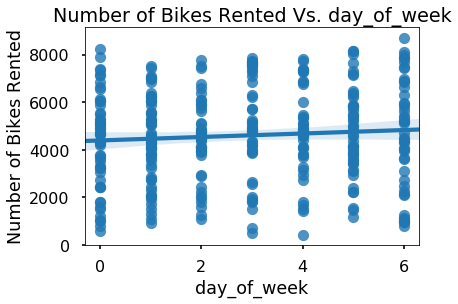

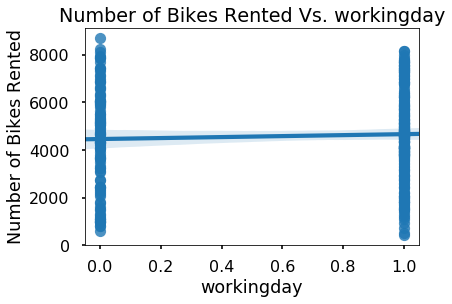

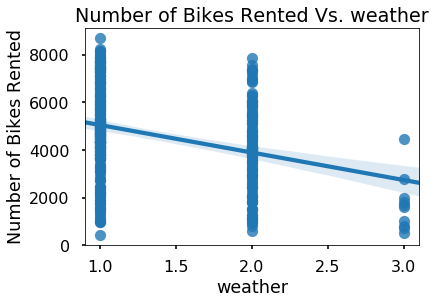

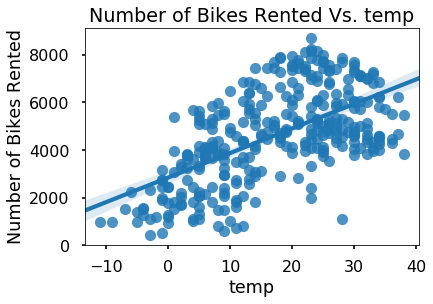

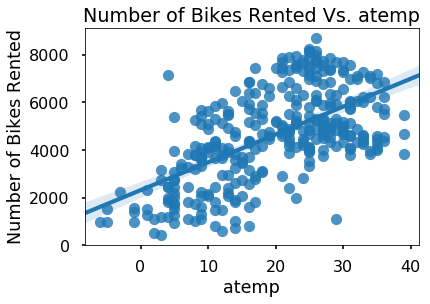

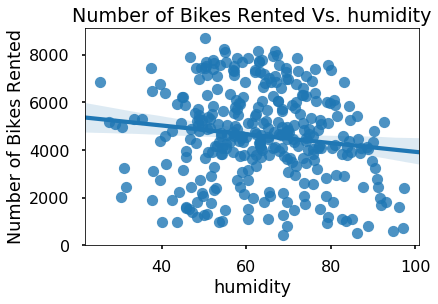

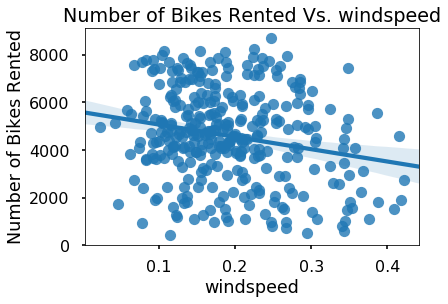

In [273]:
initPredictors = ["season", "month", "holiday", "day_of_week", "workingday", "weather", "temp", "atemp", "humidity", "windspeed"] 

for i, predictor in enumerate(initPredictors):
    fig, ax = plt.subplots()
    ax = sns.regplot(trainDf[predictor], trainDf["count"])
    ax.set_title("Number of Bikes Rented Vs. {}".format(predictor))
    ax.set_xlabel("{}".format(predictor))
    ax.set_ylabel("Number of Bikes Rented")

We observe that `season`, `month`, `temp`, and `atemp` seem to have a non-linear relationship with `number of bikes rented`.
The former is probably best described by a sinusoidal function whereas the latter two would fit a negative quadratic function.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

### Answers to Questions above

* We cannot use categorical variables directly as predictors since non-integer values have no meaning.
* The $K_j$-th category does not need to have a binary column as it is implied as the baseline, i.e. the $0$-vector.
* As a general principle, we do not want to train on the test data. This way, we avoid fitting the training data which would lead to a less general model.

In [274]:
# Create dummy variables
trainBinaryDf = pd.get_dummies(trainDf, columns=["season", "month", "day_of_week", "weather"])
testBinaryDf = pd.get_dummies(testDf, columns=["season", "month", "day_of_week", "weather"])

trainBinaryDf.head()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3
0,0,0,1,24,26,76.5833,0.118167,6073,0,1,...,0,0,1,0,0,0,0,0,1,0
1,1,0,1,15,19,73.3750,0.174129,6606,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2,0,1,26,28,56.9583,0.253733,7363,0,1,...,0,0,0,0,1,0,0,1,0,0
3,3,0,0,0,4,58.6250,0.169779,2431,0,0,...,1,0,0,0,0,0,0,1,0,0
4,4,0,1,23,23,91.7083,0.097021,1996,0,0,...,0,0,0,1,0,0,0,0,0,1


In [275]:
# Normalize predictors
for column in ["temp", "atemp", "humidity", "windspeed"]:
    colMean = np.mean(trainBinaryDf[column])
    colSD = np.std(trainBinaryDf[column])
    trainBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in trainBinaryDf[column]]
    testBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in testBinaryDf[column]]
trainBinaryDf.head()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,temp_norm,atemp_norm,humidity_norm,windspeed_norm
0,0,0,1,24,26,76.5833,0.118167,6073,0,1,...,0,0,0,0,1,0,0.624743,0.651090,0.922058,-0.930164
1,1,0,1,15,19,73.3750,0.174129,6606,0,0,...,0,0,0,1,0,0,-0.180583,-0.054841,0.697907,-0.213825
2,2,0,1,26,28,56.9583,0.253733,7363,0,1,...,1,0,0,1,0,0,0.803704,0.852785,-0.449062,0.805143
3,3,0,0,0,4,58.6250,0.169779,2431,0,0,...,0,0,0,1,0,0,-1.522794,-1.567551,-0.332616,-0.269507
4,4,0,1,23,23,91.7083,0.097021,1996,0,0,...,0,0,0,0,0,1,0.535262,0.348548,1.978781,-1.200843


In [276]:
trainBinaryDf.describe()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,temp_norm,atemp_norm,humidity_norm,windspeed_norm
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,165.000000,0.033233,0.670695,17.018127,19.543807,63.385776,0.190833,4598.447130,0.217523,0.259819,...,0.123867,0.145015,0.135952,0.640483,0.329305,0.030211,-5.366637e-17,-1.180660e-16,-8.264621e-16,1.341659e-16
std,95.695698,0.179515,0.470672,11.192515,9.930991,14.334789,0.078240,1935.319338,0.413186,0.439199,...,0.329929,0.352649,0.343256,0.480585,0.470672,0.171428,1.001514e+00,1.001514e+00,1.001514e+00,1.001514e+00
min,0.000000,0.000000,0.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.507081e+00,-2.576025e+00,-2.652747e+00,-2.156128e+00
25%,82.500000,0.000000,0.000000,7.500000,11.000000,52.702900,0.133083,3370.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.516886e-01,-8.616201e-01,-7.463695e-01,-7.392325e-01
50%,165.000000,0.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.785869e-02,1.468532e-01,-6.572679e-03,-1.581428e-01
75%,247.500000,0.000000,1.000000,26.000000,27.000000,73.500000,0.235380,5981.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,8.037042e-01,7.519372e-01,7.066402e-01,5.702098e-01
max,330.000000,1.000000,1.000000,38.000000,39.000000,97.250000,0.421642,8714.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.877473e+00,1.962105e+00,2.365957e+00,2.954455e+00


In [277]:
# Drop k-th dummies
predictors = ["holiday", "workingday", "temp_norm","atemp_norm","humidity_norm","windspeed_norm",
                  "weather_1", "weather_2", "day_of_week_0", "day_of_week_1", "day_of_week_2",
                  "day_of_week_3", "day_of_week_4", "day_of_week_5", "season_1",
                  "season_2", "season_3", "month_1", "month_2", "month_3", "month_4", "month_5",
                  "month_6", "month_7", "month_8", "month_9", "month_10", "month_11"]
trainPredict = trainBinaryDf[predictors]
testPredict = testBinaryDf[predictors]

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [278]:
# Fit OLS multilinear regression on test set
X = trainPredict
Y = trainDf["count"]

YStd = np.std(trainDf["count"])
YNorm = stats.zscore(Y)

# TODO: Investigate the effects of Y-normalization

multLinModel = sm.OLS(Y, X).fit()
predictions = multLinModel.predict(X)
multLinModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     149.5
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          2.33e-158
Time:                        02:48:29   Log-Likelihood:                -2848.0
No. Observations:                 331   AIC:                             5750.
Df Residuals:                     304   BIC:                             5853.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
holiday         -291.9271    419.812     -0.695      0.487   -1118.032     534.177
workingday       249.0522    174.910      1.424      0.156     -95.136     593.241
temp_norm        452.2448    488.180      0.926      0.355    -508.396    1412.885
atemp_norm       348.5270    449.665      0.775      0.439    -536.322    1233.376
humidity_norm   -278.5560    106.846     -2.607      0.010    -488.808     -68.304
windspeed_norm  -199.0958     83.812     -2.376      0.018    -364.020     -34.171
weather_1       3764.7156    369.018     10.202      0.000    3038.564    4490.868
weather_2       3433.5408    354.777      9.678      0.000    2735.412    4131.670
day_of_week_0   -105.6855    273.577     -0.386      0.700    -644.030     432.659
day_of_week_1   -220.0665    180.740     -1.218      0.224    -575.725     135.592
day_of_week_2   -214.1908    213.441     -1.004      0.316    -634.200     205.819
day_of_week_3    257.8665    221.214      1.166      0.245    -177.439     693.172
day_of_week_4     67.8582    216.619      0.313      0.754    -358.404     494.121
day_of_week_5     65.6577    209.617      0.313      0.754    -346.826     478.142
season_1        -586.9895    516.812     -1.136      0.257   -1603.970     429.991
season_2         206.6430    592.003      0.349      0.727    -958.299    1371.585
season_3         173.0863    465.341      0.372      0.710    -742.611    1088.783
month_1          267.1746    528.596      0.505      0.614    -772.995    1307.344
month_2          457.9919    538.638      0.850      0.396    -601.939    1517.923
month_3          872.8363    526.706      1.657      0.099    -163.615    1909.287
month_4         1335.9802    668.349      1.999      0.047      20.804    2651.157
month_5          932.3290    715.107      1.304      0.193    -474.857    2339.514
month_6          595.5610    688.387      0.865      0.388    -759.045    1950.167
month_7          414.7328    671.092      0.618      0.537    -905.841    1735.307
month_8          734.0134    666.866      1.101      0.272    -578.245    2046.272
month_9         1717.8908    527.859      3.254      0.001     679.171    2756.611
month_10        1761.1809    405.290      4.345      0.000     963.651    2558.710
month_11        1362.4070    376.946      3.614      0.000     620.654    2104.160
==============================================================================
Omnibus:                       18.164   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.729
Skew:                           0.083   Prob(JB):                       0.0210
Kurtosis:                       2.270   Cond. No.                     1.38e+16
==============================================================================

Warnings:
[1] Standard Errors assum

### Assesment of The Regression Model Above
- The following predictors have a statistically significant positive correlation with the number of bike rentals:
    * `weather_1`, `weather_2`
    * `month_4` April, `month_9` September, `month_10` October, `month_11` November
- The day of a week does not have a statistically significant relationship with bike rentals.
- The month certainly influences the number of bike rentals (as evidenced by the significant predictors above)
- Ceteris paribus, a holiday does not have a significant relationship with bike rentals.
- There is no statistical significant  difference in the coefficients assigned to `temp` and `atemp`, as both 95%-CIs have similar bounds, including 0.

In [279]:
testY = testDf["count"]
testYHat = multLinModel.predict(testPredict)
print("Test R-Squared: {}".format(r2_score(testY, testYHat)))

Test R-Squared: 0.2136480983761745


## Low $R^2$ Value Interpretation
The comparatively low $R^2$ value indicates that our model is overfitting the training data.

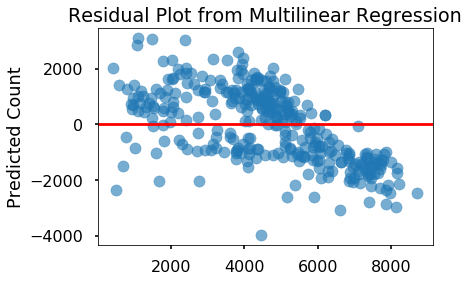

In [280]:
residuals = list(map(lambda yhat, y: yhat - y, predictions, Y)) #YNorm instead of Y
fig, ax = plt.subplots()

ax.scatter(Y, residuals, alpha=.6)
ax.set_title("Residual Plot from Multilinear Regression")
ax.axhline(y=0, color="r")
# ax.set_xlabel("Normalized True Count") True?
ax.set_ylabel("Predicted Count")

The plot reveals a non-linear relationship between the predictors and response, since the error terms are not evenly distributed around the mean, and their variance depends on y, decreasing as y grows. This violates our regression assumption of normal, homoskedastic noise.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [187]:
dpal = sns.choose_colorbrewer_palette('diverging', as_cmap=True)

NameError: name 'interact' is not defined

In [188]:
plt.pcolor(X.corr(), cmap=dpal, alpha=.6)
ax = plt.gca()
ax.set_title("Correlation Matrix")
plt.xticks(range(len(predictors)), predictors, rotation=90)
plt.yticks(range(len(predictors)), predictors)

NameError: name 'dpal' is not defined

TODO: Cut correlation matrix in half

We observe the following relationships:
* `temp_norm` and `atemp_norm` are unsurprisingly very much positively correlated.
* `weather_1` and `weather_2` are negatively correlated, which makes sense since they derive from categorical data.
* We can see "boxes" for `day_of_week_j` and `month_k` which is intuitive.
* `temp_norm` and `atemp_norm` are correlated with the months.
* Naturally, the seasons are correlated with the months.

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [248]:
# Implement step-wise forward selection

# The set of predictors
predictors = ["holiday", "workingday", "temp_norm", "atemp_norm", "humidity_norm", "windspeed_norm",
              "weather_1", "weather_2", "day_of_week_0", "day_of_week_1", "day_of_week_2",
              "day_of_week_3", "day_of_week_4", "day_of_week_5", "season_1",
              "season_2", "season_3", "month_1", "month_2", "month_3", "month_4", "month_5",
              "month_6", "month_7", "month_8", "month_9", "month_10", "month_11"]


forwardPredictors = []
forwardModels = []

for _ in range(len(predictors)):   
    
    betterModel, betterPredictor, betterBIC = None, None, sys.maxsize
    
    for addedPredictor in predictors:
        X = trainBinaryDf[forwardPredictors + [addedPredictor]]
        newModel = sm.OLS(Y, X).fit()
        
        bestBIC = min([model.bic for model in forwardModels] + [betterBIC])
        if newModel.bic < bestBIC:
            betterModel = newModel
            betterPredictor = addedPredictor
            betterBIC = newModel.bic

    if betterModel:
        forwardModels.append(betterModel)
        forwardPredictors.append(betterPredictor)
    else:
        break

forwardBICs = [model.bic for model in forwardModels]
forwardRSquareds = [model.rsquared for model in forwardModels]
print("Predictors: {}".format(forwardPredictors))
print("Rsquareds: {}".format(forwardRSquareds))
print("BICs: {}".format(forwardBICs))

Predictors: ['weather_1', 'weather_2', 'atemp_norm', 'season_1', 'month_9', 'month_10']
Rsquareds: [0.64395624854990763, 0.8639787776255895, 0.90838119973133979, 0.91731251671238012, 0.91971618997049387, 0.92113561882483164]
BICs: [6240.1026012557049, 5927.4023858649416, 5802.4017690011524, 5774.2537953131086, 5770.291328390842, 5770.188969866972]


## Results
The step-wise regression yields a 9-parameter model. `temp_norm` and some `season`/`month` redundancies (by collinearity) have been resolved.

## Testing

In [249]:
testY = testDf["count"]
testPredict = testBinaryDf[chosenPredictors]
testYHat = forwardModels[-1].predict(testPredict)
print("Test R-Squared: {}".format(r2_score(testY, testYHat)))

Test R-Squared: 0.2506256818447151


Testing the resulting model on the test dataset yields a slightly higher $R^2$ value than the one in Part (b).

In [254]:
# Implement step-wise backward selection

# The set of predictors
predictors = set(["holiday", "workingday", "temp_norm", "atemp_norm", "humidity_norm", "windspeed_norm",
                  "weather_1", "weather_2", "day_of_week_0", "day_of_week_1", "day_of_week_2",
                  "day_of_week_3", "day_of_week_4", "day_of_week_5", "season_1",
                  "season_2", "season_3", "month_1", "month_2", "month_3", "month_4", "month_5",
                  "month_6", "month_7", "month_8", "month_9", "month_10", "month_11"])


backwardPredictors = set(predictors)
backwardModels = []

for _ in range(len(predictors)):   
    
    betterModel, betterPredictor, betterBIC = None, None, sys.maxsize
    
    for removedPredictor in backwardPredictors:
        X = trainBinaryDf[list(backwardPredictors - set([removedPredictor]))]
        newModel = sm.OLS(Y, X).fit()
        
        bestBIC = min([model.bic for model in backwardModels] + [betterBIC])
        if newModel.bic < bestBIC:
            betterModel = newModel
            betterPredictor = removedPredictor
            betterBIC = newModel.bic

    if betterModel:
        backwardModels.append(betterModel)
        backwardPredictors.remove(betterPredictor)
    else:
        break

backwardBICs = [model.bic for model in backwardModels]
backwardRSquareds = [model.rsquared for model in backwardModels]
print("Predictors: {}".format(backwardPredictors))
print("Rsquareds: {}".format(backwardRSquareds))
print("BICs: {}".format(backwardBICs))

Predictors: {'workingday', 'month_10', 'day_of_week_4', 'holiday', 'month_4', 'day_of_week_3', 'temp_norm', 'day_of_week_1', 'windspeed_norm', 'humidity_norm', 'day_of_week_2', 'day_of_week_5', 'month_11', 'weather_1', 'month_5', 'weather_2', 'month_9'}
Rsquareds: [0.92994056670167369, 0.92992837168733355, 0.9298968113798517, 0.92978803073009075, 0.92966522229677928, 0.92951076473793859, 0.92928993647732749, 0.92904207914158832, 0.92884660316028356, 0.92802592095001601, 0.92727081325831295]
BICs: [5847.0456526871676, 5841.3011453754661, 5835.6480760544291, 5830.359179526582, 5825.1355107083382, 5820.0594825984072, 5815.2926981727869, 5810.6487929561072, 5805.7572648372479, 5803.7510464037405, 5801.4034860623051]


### Testing

In [253]:
testY = testDf["count"]
testPredict = testBinaryDf[list(backwardPredictors)]
testYHat = backwardModels[-1].predict(testPredict)
print("Test R-Squared: {}".format(r2_score(testY, testYHat)))

Test R-Squared: 0.20787623890193307


Testing the resulting model on the test dataset yields a marginally lower $R^2$ value than the one in Part (b).

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [287]:
# Work in Progress...

# forwardModel = forwardModels[-1]
# backwardModel = backwardModels[-1]

# kf = KFold(n_splits=10)
# X = trainPredict
# Y = trainDf["count"]

# multLinRSquares = []
# forwardRSquares = []
# backwardRSquares = []

# for trainTest, trainIndex in kf.split(X):
#     print(trainTest, trainIndex)
#     multLinPredict = X[trainTest]
#     forwardPredict = X[trainTest][list(forwardPredictors)]
#     backwardPredict = X[trainTest][list(backwardPredictors)]
    
#     multLinYHat = model.predict(multLinPredict)
#     forwardYHat = model.predict(forwardPredict)
#     backwardYHat = model.predict(backwardPredict)

#     multLinRSquares.append(r2_score(Y, multLinYHat))
#     forwardRSquares.append(r2_score(Y, forwardYHat))
#     backwardRSquares.append(r2_score(Y, backwardYHat))
    
# multLinRSquares, forwardRSquares, backwardRSquares

[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 28

KeyError: '[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51\n  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69\n  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87\n  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105\n 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123\n 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141\n 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159\n 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177\n 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195\n 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213\n 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231\n 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249\n 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267\n 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285\n 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303\n 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321\n 322 323 324 325 326 327 328 329 330] not in index'

your answers here